In [ ]:
from typing import List

import numpy as np
import tensorflow as tf
import h5py
import os
from tensorflow.keras.utils import to_categorical
from tensorflow import Tensor
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from typing import Tuple, Dict, Any, Sequence

from collections import defaultdict
import tensorflow as tf

In [ ]:
%cd drive/MyDrive/SCA-Datasets/

/content/drive/MyDrive/SCA-Datasets


In [ ]:
# start med train
dataset_name = "training_0"
shard = []
attack_byte = 0
attack_point = "sub_bytes_in"
max_trace_length = 5000
num_traces = 256
num_traces_per_shard = 256
full_key = False
x_List: List[Tensor] = []
y_List: List[Tensor] = []

# må åpne filen for å lese informasjon
with (h5py.File(f"{dataset_name}.hdf5", "r")) as f:
    for group in f.keys():
        group_name = f[group]

        x_shard = group_name["traces"][:num_traces_per_shard, :5000, :]
        x_shard = tf.convert_to_tensor(x_shard, dtype="float32")

        y_shard = group_name["sub_bytes_in"][attack_byte]
        y_shard = y_shard[:num_traces_per_shard]
        y_shard = to_categorical(y_shard, 256)
        y_shard = tf.convert_to_tensor(y_shard, dtype="uint8")

        x_List.append(x_shard)
        y_List.append(y_shard)
    x: Tensor = tf.concat(x_List, axis=0)
    y: Tensor = tf.concat(y_List, axis=0)
x_train = x
y_train = y

# For testdatasettet, som bør skaleres ned da det er 1:1 med treningssettet
dataset_name = "test_0"
shard = []
attack_byte = 0
attack_point = "sub_bytes_in"
max_trace_length = 5000
num_traces = 256
num_traces_per_shard = 256
full_key = False
x_List: List[Tensor] = []
y_List: List[Tensor] = []

# må åpne filen for å lese informasjon
with (h5py.File(f"{dataset_name}.hdf5", "r")) as f:
    for group in f.keys():
        group_name = f[group]

        x_shard = group_name["traces"][:num_traces_per_shard, :5000, :]
        x_shard = tf.convert_to_tensor(x_shard, dtype="float32")

        y_shard = group_name["sub_bytes_in"][attack_byte]
        y_shard = y_shard[:num_traces_per_shard]
        y_shard = to_categorical(y_shard, 256)
        y_shard = tf.convert_to_tensor(y_shard, dtype="uint8")

        x_List.append(x_shard)
        y_List.append(y_shard)
    x: Tensor = tf.concat(x_List, axis=0)
    y: Tensor = tf.concat(y_List, axis=0)
x_test = x
y_test = y

In [ ]:
config = """{
    "model": "cnn",
    "device": "stm32f0",
    "algorithm": "tinyaes",
    "version": "10",
    "attack_points": [
        "sub_bytes_in"

    ],
    "attack_bytes": [
        "0"
    ],
    "max_trace_len": 5000,
    "num_shards": 256,
    "num_traces_per_shard": 256,
    "batch_size": 32,
    "epochs": 30,
    "optimizer_parameters": {
        "lr": 0.001,
        "multi_gpu_lr": 0.001
    },
    "model_parameters": {
        "activation": "relu",
        "initial_filters": 8,
        "initial_pool_size": 4,
        "block_kernel_size": 3,
        "blocks_stack1": 3,
        "blocks_stack2": 4,
        "blocks_stack3": 4,
        "blocks_stack4": 3,
        "dense_dropout": 0.1,
        "use_pooling": true,
    }
}"""

In [ ]:
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""Intro model."""

from typing import Any, Dict, Tuple

from tensorflow import Tensor
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

#from scaaml.utils import display_config
def display_config(config_name: str, config: Dict[str, str]) -> None:
    """Pretty print a config object in terminal.

    Args:
        config_name (str): name of the config
        config (dict): config to display
    """
    cprint(f"[{config_name}]", "magenta")
    cnt = 1
    for k, v in config.items():
        color: Color = "yellow"
        if cnt % 2:
            color = "cyan"
        cprint(f"{k}:{v}", color)
        cnt += 1
#from scaaml.utils import get_num_gpu
def get_num_gpu() -> int:
    return len(tf.config.list_physical_devices("GPU"))

# pylint: disable=too-many-positional-arguments
def block(x: Tensor,
          filters: int,
          kernel_size: int = 3,
          strides: int = 1,
          conv_shortcut: bool = False,
          activation: str = "relu") -> Tensor:
    """Residual block with pre-activation
    From: https://arxiv.org/pdf/1603.05027.pdf

    Args:
        x: input tensor.
        filters (int): filters of the bottleneck layer.

        kernel_size(int, optional): kernel size of the bottleneck layer.
        defaults to 3.

        strides (int, optional): stride of the first layer.
        defaults to 1.

        conv_shortcut (bool, optional): Use convolution shortcut if True,
        otherwise identity shortcut. Defaults to False.

        use_batchnorm (bool, optional): Use batchnormalization if True.
        Defaults to True.

        activation (str, optional): activation function. Defaults to "relu".

    Returns:
        Output tensor for the residual block.
    """

    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)

    if conv_shortcut:
        shortcut = layers.Conv1D(4 * filters, 1, strides=strides)(x)
    else:
        if strides > 1:
            shortcut = layers.MaxPooling1D(1, strides=strides)(x)
        else:
            shortcut = x

    x = layers.Conv1D(filters, 1, use_bias=False, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)

    x = layers.Conv1D(filters,
                      kernel_size,
                      strides=strides,
                      use_bias=False,
                      padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)

    x = layers.Conv1D(4 * filters, 1)(x)
    x = layers.Add()([shortcut, x])
    return x


# pylint: disable=too-many-positional-arguments
def stack(x: Tensor,
          filters: int,
          blocks: int,
          kernel_size: int = 3,
          strides: int = 2,
          activation: str = "relu") -> Tensor:
    """A set of stacked residual blocks.
    Args:
        filters (int): filters of the bottleneck layer.

        blocks (int): number of conv blocks to stack.

        kernel_size(int, optional): kernel size of the bottleneck layer.
        defaults to 3.

        strides (int, optional): stride used in the last block.
        defaults to 2.

        conv_shortcut (bool, optional): Use convolution shortcut if True,
        otherwise identity shortcut. Defaults to False.

        activation (str, optional): activation function. Defaults to "relu".

    Returns:
        tensor:Output tensor for the stacked blocks.
  """
    x = block(x,
              filters,
              kernel_size=kernel_size,
              activation=activation,
              conv_shortcut=True)
    for _ in range(2, blocks):
        x = block(x, filters, kernel_size=kernel_size, activation=activation)
    x = block(x, filters, strides=strides, activation=activation)
    return x


from typing import Any, Dict, Tuple
from tensorflow.keras.models import Model


# pylint: disable=C0103
def Resnet1D(input_shape: Tuple[int, ...], attack_point: str,
             mdl_cfg: Dict[str, Any], optim_cfg: Dict[str,
                                                      Any]) -> Model:
    del attack_point  # unused

    pool_size = mdl_cfg["initial_pool_size"]
    filters = mdl_cfg["initial_filters"]
    block_kernel_size = mdl_cfg["block_kernel_size"]
    activation = mdl_cfg["activation"]
    dense_dropout = mdl_cfg["dense_dropout"]
    num_blocks = [
        mdl_cfg["blocks_stack1"], mdl_cfg["blocks_stack2"],
        mdl_cfg["blocks_stack3"], mdl_cfg["blocks_stack4"]
    ]

    inputs = layers.Input(shape=input_shape)
    x = inputs

    # stem endring, VÅRT DATASETT ER IKKE OVERSAMPLET
    if mdl_cfg.get("use_pooling", True):
      x = layers.MaxPool1D(pool_size=pool_size)(x)
    #else:
    #  x = layers.Conv1D(filters, 3, strides=1, padding="same")(x)

    # trunk: stack of residual block
    for block_idx in range(4):
        filters *= 2
        x = stack(x,
                  filters,
                  num_blocks[block_idx],
                  kernel_size=block_kernel_size,
                  activation=activation)

    # head model: dense
    x = layers.GlobalAveragePooling1D()(x)
    for _ in range(1):
        x = layers.Dropout(dense_dropout)(x)
        x = layers.Dense(256)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)

    outputs = layers.Dense(256, activation="softmax")(x)

    model: Model[Any, Any] = Model(inputs=inputs, outputs=outputs)
    model.summary()

    if get_num_gpu() > 1:
        lr = optim_cfg["multi_gpu_lr"]
    else:
        lr = optim_cfg["lr"]

    model.compile(loss=["categorical_crossentropy"],
                  metrics=["acc"],
                  optimizer=Adam(lr))
    return model





In [ ]:
def build_model(hp):
    mdl_cfg = {
        "initial_pool_size": hp.Choice("initial_pool_size", [2, 4, 8, 16]),
        "initial_filters": hp.Int("initial_filters", min_value=8, max_value=64, step=8),
        "block_kernel_size": hp.Choice("block_kernel_size", [2,3, 5, 7, 9]),
        "activation": hp.Choice("activation", ["relu", "elu", "tanh"]),
        "dense_dropout": hp.Float("dense_dropout", 0.0, 0.5, step=0.1),
        "use_pooling": hp.Boolean("use_pooling"),
        "blocks_stack1": hp.Int("blocks_stack1", 2, 5),
        "blocks_stack2": hp.Int("blocks_stack2", 2, 5),
        "blocks_stack3": hp.Int("blocks_stack3", 2, 5),
        "blocks_stack4": hp.Int("blocks_stack4", 2, 5),
    }

    optim_cfg = {
        "lr": hp.Float("lr", 1e-4, 1e-2, sampling="log")
            }

    input_shape = x_train.shape[1:]
    attack_point = "sub_bytes_in"    # eller det du trenger her

    return Resnet1D(input_shape, attack_point, mdl_cfg, optim_cfg)

In [ ]:
!pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.0 MB/s eta 0:00:00


In [ ]:
#setter epochs til 20 basert på erfaring fra de tidligere treningene
import kerastuner as kt
from tensorflow.keras.callbacks import EarlyStopping # Import EarlyStopping

early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

tuner = kt.Hyperband(build_model,
                     objective='val_acc', # Or 'val_loss'
                     max_epochs=20,
                     factor=4,
                     directory='my_dir',
                     project_name='intro_to_kt')

tuner.search(x_train, y_train, epochs=20, validation_data=(x_test, y_test),callbacks=[early_stop])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hps.
model = tuner.hypermodel.build(best_hps)

Trial 28 Complete [00h 08m 08s]
val_acc: 0.21455270051956177

Best val_acc So Far: 0.24419423937797546
Total elapsed time: 05h 31m 10s


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 5000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 2500, 1)   │          0 │ input_layer_1[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2500, 1)   │          4 │ max_pooling1d_4[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_34       │ (None, 2500, 1)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_38 (Conv1D)  │ (None, 2500, 16)  │         16 │ activation_34[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2500, 16)  │         64 │ conv1d_38[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_35       │ (None, 2500, 16)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_39 (Conv1D)  │ (None, 2500, 16)  │      2,304 │ activation_35[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2500, 16)  │         64 │ conv1d_39[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_36       │ (None, 2500, 16)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_37 (Conv1D)  │ (None, 2500, 64)  │        128 │ activation_34[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, 2500, 64)  │      1,088 │ activation_36[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 2500, 64)  │          0 │ conv1d_37[0][0],  │
│                     │                   │            │ conv1d_40[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2500, 64)  │        256 │ add_11[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_37       │ (None, 2500, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_41 (Conv1D)  │ (None, 2500, 16)  │      1,024 │ activation_37[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2500, 16)  │         64 │ conv1d_41[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_38       │ (None, 2500, 16)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,705,940 (6.51 MB)

 Trainable params: 1,694,738 (6.46 MB)

 Non-trainable params: 11,202 (43.76 KB)

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

{'initial_pool_size': 2, 'initial_filters': 8, 'block_kernel_size': 9, 'activation': 'tanh', 'dense_dropout': 0.4, 'use_pooling': True, 'blocks_stack1': 5, 'blocks_stack2': 4, 'blocks_stack3': 4, 'blocks_stack4': 4, 'lr': 0.00027827185198563305, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0020'}


In [ ]:
# Get the best 3 sets of hyperparameters
best_hps_list = tuner.get_best_hyperparameters(num_trials=3)  # Change num_trials as needed

# Access the hyperparameters for each model:
for i, hps in enumerate(best_hps_list):
    print(f"Hyperparameters for model {i + 1}:")
    print(hps.values)
    print("-" * 20)  # Separator

Hyperparameters for model 1:
{'initial_pool_size': 2, 'initial_filters': 8, 'block_kernel_size': 9, 'activation': 'tanh', 'dense_dropout': 0.4, 'use_pooling': True, 'blocks_stack1': 5, 'blocks_stack2': 4, 'blocks_stack3': 4, 'blocks_stack4': 4, 'lr': 0.00027827185198563305, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0020'}
--------------------
Hyperparameters for model 2:
{'initial_pool_size': 2, 'initial_filters': 8, 'block_kernel_size': 3, 'activation': 'relu', 'dense_dropout': 0.0, 'use_pooling': False, 'blocks_stack1': 4, 'blocks_stack2': 3, 'blocks_stack3': 2, 'blocks_stack4': 2, 'lr': 0.0001948525099608208, 'tuner/epochs': 10, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
--------------------
Hyperparameters for model 3:
{'initial_pool_size': 2, 'initial_filters': 64, 'block_kernel_size': 2, 'activation': 'relu', 'dense_dropout': 0.1, 'use_pooling': True, 'blocks_stack1': 4, 'blocks_stack2': 5, 'blocks_

Looking closer at the best performin model, and trying other activation functions. Interesting that the three best models are all quite different

In [ ]:
def build_model(hp):
    mdl_cfg = {
        "initial_pool_size": hp.Choice("initial_pool_size", [1,2, 4]),  # Focus on 1,2, 4
        "initial_filters": hp.Int("initial_filters", min_value=8, max_value=16, step=8),  # Focus on 8, 16
        "block_kernel_size": hp.Choice("block_kernel_size", [3,7, 9,11]),  # Focus on 7, 9, and explore 11
        "activation": hp.Choice("activation", ["tanh", "selu", "sigmoid"]),  # Include selu, sigmoid
        "dense_dropout": hp.Float("dense_dropout", 0.3, 0.5, step=0.05),  # Focus on 0.3 to 0.5 with finer steps
        "use_pooling": hp.Boolean("use_pooling"),
        "blocks_stack1": hp.Int("blocks_stack1", 4, 6),  # Focus on 4, 5, 6
        "blocks_stack2": hp.Int("blocks_stack2", 3, 5),  # Focus on 3, 4, 5
        "blocks_stack3": hp.Int("blocks_stack3", 3, 5),  # Focus on 3, 4, 5
        "blocks_stack4": hp.Int("blocks_stack4", 3, 5),  # Focus on 3, 4, 5
    }

    optim_cfg = {
        "lr": hp.Float("lr", 1e-4, 1e-3, sampling="log")  # Narrow down learning rate range
    }


    input_shape = x_train.shape[1:]
    attack_point = "sub_bytes_in"

    return Resnet1D(input_shape, attack_point, mdl_cfg, optim_cfg)


In [ ]:
import kerastuner as kt
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import matplotlib.pyplot as plt


# Create a TensorBoard callback
tensorboard_callback = TensorBoard(log_dir="./logs", histogram_freq=1)

# Create an EarlyStopping callback
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# Create the tuner
tuner = kt.Hyperband(build_model,
                     objective='val_acc',
                     max_epochs=20,
                     factor=4,
                     directory='my_dir',
                     project_name='kt_run_2')

# Run the tuner with the callbacks
tuner.search(x_train, y_train, epochs=20, validation_data=(x_test, y_test),
                    callbacks=[early_stop, tensorboard_callback])  # Added callbacks




Trial 44 Complete [00h 53m 00s]
val_acc: 0.003921568859368563

Best val_acc So Far: 0.35600489377975464
Total elapsed time: 07h 42m 39s


AttributeError: 'NoneType' object has no attribute 'history'

NameError: name 'history' is not defined

In [ ]:
%cd drive/MyDrive/SCA-Datasets/my_dir/


/content/drive/MyDrive/SCA-Datasets/my_dir


In [ ]:
import json
import os

trial_directory = "kt_run_2"

trials = []
for trial_id in os.listdir(trial_directory):
    trial_path = os.path.join(trial_directory, trial_id, "trial.json")
    if os.path.exists(trial_path):
        with open(trial_path, 'r') as f:
            trial_data = json.load(f)
            trials.append(trial_data)

In [ ]:
for trial in trials:
    hyperparameters = trial['hyperparameters']['values']
    metrics = trial['metrics']['metrics']  # Assuming metrics are stored here
    # ... extract other information as needed ...

    print(f"Trial ID: {trial['trial_id']}")
    print(f"Hyperparameters: {hyperparameters}")
    print(f"Metrics: {metrics}")
    print("-" * 20)

Trial ID: 0000
Hyperparameters: {'initial_pool_size': 1, 'initial_filters': 8, 'block_kernel_size': 11, 'activation': 'tanh', 'dense_dropout': 0.45, 'use_pooling': False, 'blocks_stack1': 5, 'blocks_stack2': 3, 'blocks_stack3': 3, 'blocks_stack4': 3, 'lr': 0.0002101311105839209, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}
Metrics: {'acc': {'direction': 'max', 'observations': [{'value': [0.0139312744140625], 'step': 1}]}, 'loss': {'direction': 'min', 'observations': [{'value': [4.864314079284668], 'step': 1}]}, 'val_acc': {'direction': 'max', 'observations': [{'value': [0.020986519753932953], 'step': 1}]}, 'val_loss': {'direction': 'min', 'observations': [{'value': [4.507480144500732], 'step': 1}]}}
--------------------
Trial ID: 0001
Hyperparameters: {'initial_pool_size': 2, 'initial_filters': 16, 'block_kernel_size': 11, 'activation': 'tanh', 'dense_dropout': 0.5, 'use_pooling': True, 'blocks_stack1': 6, 'blocks_stack2': 5, 'blocks_stack3': 5, 'b

In [ ]:
best_trials = sorted(trials, key=lambda trial: trial['metrics']['metrics']['val_acc']['observations'][0]['value'], reverse=True)  # Sort by validation accuracy
print(f"Best trial: {best_trials[0]}")
print(f"Best trial: {best_trials[1]}")
print(f"Best trial: {best_trials[2]}")



Best trial: {'trial_id': '0028', 'hyperparameters': {'space': [{'class_name': 'Choice', 'config': {'name': 'initial_pool_size', 'default': 1, 'conditions': [], 'values': [1, 2, 4], 'ordered': True}}, {'class_name': 'Int', 'config': {'name': 'initial_filters', 'default': None, 'conditions': [], 'min_value': 8, 'max_value': 16, 'step': 8, 'sampling': 'linear'}}, {'class_name': 'Choice', 'config': {'name': 'block_kernel_size', 'default': 3, 'conditions': [], 'values': [3, 7, 9, 11], 'ordered': True}}, {'class_name': 'Choice', 'config': {'name': 'activation', 'default': 'tanh', 'conditions': [], 'values': ['tanh', 'selu', 'sigmoid'], 'ordered': False}}, {'class_name': 'Float', 'config': {'name': 'dense_dropout', 'default': 0.3, 'conditions': [], 'min_value': 0.3, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}}, {'class_name': 'Boolean', 'config': {'name': 'use_pooling', 'default': False, 'conditions': []}}, {'class_name': 'Int', 'config': {'name': 'blocks_stack1', 'default': None, '

Interestingly we see that the highest performin model this far uses tanh, and no max pooling. The kernel filter is also best when its large? maybe the filter should be close to the point of interest for one byte? Testing this further, with a smaller model space to see if we can push the performance. Also intersting to see that RELU (not in this) is not the highest performing

In [ ]:
def build_model(hp):
        mdl_cfg = {
            "initial_pool_size": hp.Choice("initial_pool_size", [2]),
            "initial_filters": hp.Int("initial_filters", min_value=8, max_value=16, step=8),
            "block_kernel_size": hp.Choice("block_kernel_size", [9, 11, 13, 15]),  # Explore larger kernels
            "activation": hp.Choice("activation", ["tanh", "selu"]),  # Keep tanh and selu
            "dense_dropout": hp.Float("dense_dropout", 0.3, 0.4, step=0.05), # Smaller range
            "use_pooling": hp.Boolean("use_pooling", default =True),
            "blocks_stack1": hp.Int("blocks_stack1", 5, 6),
            "blocks_stack2": hp.Int("blocks_stack2", 3, 4),
            "blocks_stack3": hp.Int("blocks_stack3", 4, 5),
            "blocks_stack4": hp.Int("blocks_stack4", 4, 5),
        }

        optim_cfg = {
            "lr": hp.Float("lr", 5e-4, 1e-3, sampling="log") # Refined learning rate range
        }

        input_shape = x_train.shape[1:]
        attack_point = "sub_bytes_in"

        return Resnet1D(input_shape, attack_point, mdl_cfg, optim_cfg)

In [ ]:
import kerastuner as kt
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import matplotlib.pyplot as plt


# Create a TensorBoard callback
tensorboard_callback = TensorBoard(log_dir="./logs", histogram_freq=1)

# Create an EarlyStopping callback
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# Create the tuner
#with reduced max epocs
tuner = kt.Hyperband(build_model,
                     objective='val_acc',
                     max_epochs=15,
                     factor=4,
                     directory='my_dir',
                     project_name='kt_run_3')

# Run the tuner with the callbacks
tuner.search(x_train, y_train, epochs=15, validation_data=(x_test, y_test),
                    callbacks=[early_stop, tensorboard_callback])  # Added callbacks




Trial 11 Complete [00h 06m 04s]
val_acc: 0.003921568859368563

Best val_acc So Far: 0.004243259783834219
Total elapsed time: 02h 25m 12s


INGEN AV MODELLENE KONVERGERTE, forsøker å se litt nærmere på den beste modellen fra 2 igjen, for å se om de konvergerer


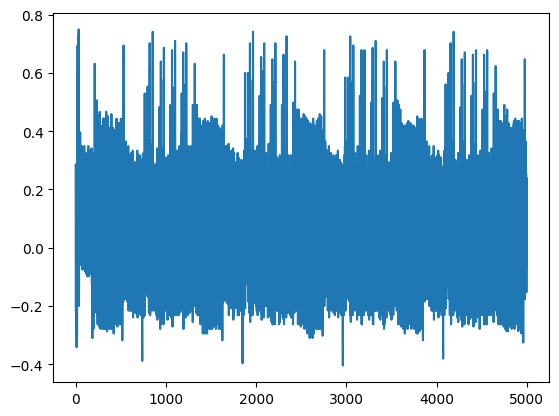

In [ ]:
#checking data to make sure it is still correct
x_train.shape
plt.plot(x_train[0])

In [ ]:
def build_model(hp):
    mdl_cfg = {
        "initial_pool_size": hp.Choice("initial_pool_size", [2]),  # Keep initial_pool_size at 2
        "initial_filters": hp.Int("initial_filters", min_value=8, max_value=16, step=8), # Keep initial_filters flexible
        "block_kernel_size": hp.Choice("block_kernel_size", [9, 11, 13]),  # Explore around 11
        "activation": hp.Choice("activation", ["tanh"]),  # Fix activation to 'tanh'
        "dense_dropout": hp.Float("dense_dropout", 0.4, 0.5, step=0.05),  # Explore around 0.45
        "use_pooling": hp.Boolean("use_pooling", default=False),  # use_pooling is False
        "blocks_stack1": hp.Int("blocks_stack1", 5, 7),  # Explore around 6
        "blocks_stack2": hp.Int("blocks_stack2", 2, 4),  # Explore around 3
        "blocks_stack3": hp.Int("blocks_stack3", 4, 6),  # Explore around 5
        "blocks_stack4": hp.Int("blocks_stack4", 4, 6),  # Explore around 5
    }

    optim_cfg = {
        "lr": hp.Float("lr", 1e-4, 5e-4, sampling="log")  # Explore around 0.00012
    }

    input_shape = x_train.shape[1:]
    attack_point = "sub_bytes_in"

    return Resnet1D(input_shape, attack_point, mdl_cfg, optim_cfg)

In [ ]:
import kerastuner as kt
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import matplotlib.pyplot as plt


# Create a TensorBoard callback
tensorboard_callback = TensorBoard(log_dir="./logs", histogram_freq=1)

# Create an EarlyStopping callback
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# Create the tuner
tuner = kt.Hyperband(build_model,
                     objective='val_acc',
                     max_epochs=20,
                     factor=4,
                     directory='my_dir',
                     project_name='kt_run_4')

# Run the tuner with the callbacks
tuner.search(x_train, y_train, epochs=20, validation_data=(x_test, y_test),
                    callbacks=[early_stop, tensorboard_callback])  # Added callbacks




Trial 44 Complete [00h 22m 13s]
val_acc: 0.24471507966518402

Best val_acc So Far: 0.36747854948043823
Total elapsed time: 06h 55m 37s


In [ ]:
# Get the best 3 sets of hyperparameters
best_hps_list = tuner.get_best_hyperparameters(num_trials=3)  # Change num_trials as needed

# Access the hyperparameters for each model:
for i, hps in enumerate(best_hps_list):
    print(f"Hyperparameters for model {i + 1}:")
    print(hps.values)
    print("-" * 20)  # Separator

Hyperparameters for model 1:
{'initial_pool_size': 2, 'initial_filters': 8, 'block_kernel_size': 13, 'activation': 'tanh', 'dense_dropout': 0.45, 'use_pooling': False, 'blocks_stack1': 6, 'blocks_stack2': 2, 'blocks_stack3': 5, 'blocks_stack4': 6, 'lr': 0.00010283965194405868, 'tuner/epochs': 20, 'tuner/initial_epoch': 5, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0022'}
--------------------
Hyperparameters for model 2:
{'initial_pool_size': 2, 'initial_filters': 8, 'block_kernel_size': 9, 'activation': 'tanh', 'dense_dropout': 0.45, 'use_pooling': False, 'blocks_stack1': 5, 'blocks_stack2': 4, 'blocks_stack3': 6, 'blocks_stack4': 5, 'lr': 0.00012990411675116838, 'tuner/epochs': 20, 'tuner/initial_epoch': 5, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0031'}
--------------------
Hyperparameters for model 3:
{'initial_pool_size': 2, 'initial_filters': 8, 'block_kernel_size': 9, 'activation': 'tanh', 'dense_dropout': 0.4, 'use_pooling': True, 'blocks_stack1': 5

And now we look at the result after running 4 searches where one of them never converged



In [ ]:
%cd my_dir


/content/drive/MyDrive/SCA-Datasets/my_dir


In [ ]:
import json
import os
trial_directories = ["kt_run_1", "kt_run_2", "kt_run_3", "kt_run_4"]  # List of directory names

trials = []
for directory in trial_directories:  # Loop through each directory name
    for trial_id in os.listdir(directory):  # List files within each directory
        trial_path = os.path.join(directory, trial_id, "trial.json")
        if os.path.exists(trial_path):
            with open(trial_path, 'r') as f:
                trial_data = json.load(f)
                trials.append(trial_data)

In [ ]:
# ... (previous code to load trials from multiple directories) ...

# Sort trials by validation accuracy in descending order
best_trials = sorted(trials,
                    key=lambda trial: trial['metrics']['metrics'].get('val_acc', {}).get('observations', [{}])[0].get('value', [0])[0], # Access val_acc safely using get() and provide default values
                    reverse=True)
# Print the top 10 best trials
for i in range(min(10, len(best_trials))):  # Limit to 10 or the total number of trials
    trial = best_trials[i]
    hyperparameters = trial['hyperparameters']['values']
    val_acc = trial['metrics']['metrics']['val_acc']['observations'][0]['value'][0]  # Extract validation accuracy

    print(f"Trial Rank: {i + 1}")
    print(f"Validation Accuracy: {val_acc}")
    print(f"Hyperparameters: {hyperparameters}")
    print("-" * 20)  # Separator

Trial Rank: 1
Validation Accuracy: 0.36747854948043823
Hyperparameters: {'initial_pool_size': 2, 'initial_filters': 8, 'block_kernel_size': 13, 'activation': 'tanh', 'dense_dropout': 0.45, 'use_pooling': False, 'blocks_stack1': 6, 'blocks_stack2': 2, 'blocks_stack3': 5, 'blocks_stack4': 6, 'lr': 0.00010283965194405868, 'tuner/epochs': 20, 'tuner/initial_epoch': 5, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0022'}
--------------------
Trial Rank: 2
Validation Accuracy: 0.35600489377975464
Hyperparameters: {'initial_pool_size': 2, 'initial_filters': 8, 'block_kernel_size': 11, 'activation': 'tanh', 'dense_dropout': 0.45, 'use_pooling': False, 'blocks_stack1': 6, 'blocks_stack2': 3, 'blocks_stack3': 5, 'blocks_stack4': 5, 'lr': 0.00012005088726311273, 'tuner/epochs': 20, 'tuner/initial_epoch': 5, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0022'}
--------------------
Trial Rank: 3
Validation Accuracy: 0.33814337849617004
Hyperparameters: {'initial_pool_size': 2,

In [ ]:
best_hyperparameters = best_trials[0]['hyperparameters']['values']  # Assuming best_trials is sorted


In [ ]:
# Save the hyperparameters to a JSON file
with open('best_hyperparameters.json', 'w') as f:
    json.dump(best_hyperparameters, f, indent=4)  # Use indent for readability